# **Training object detection model with custom data using YOLOv11**

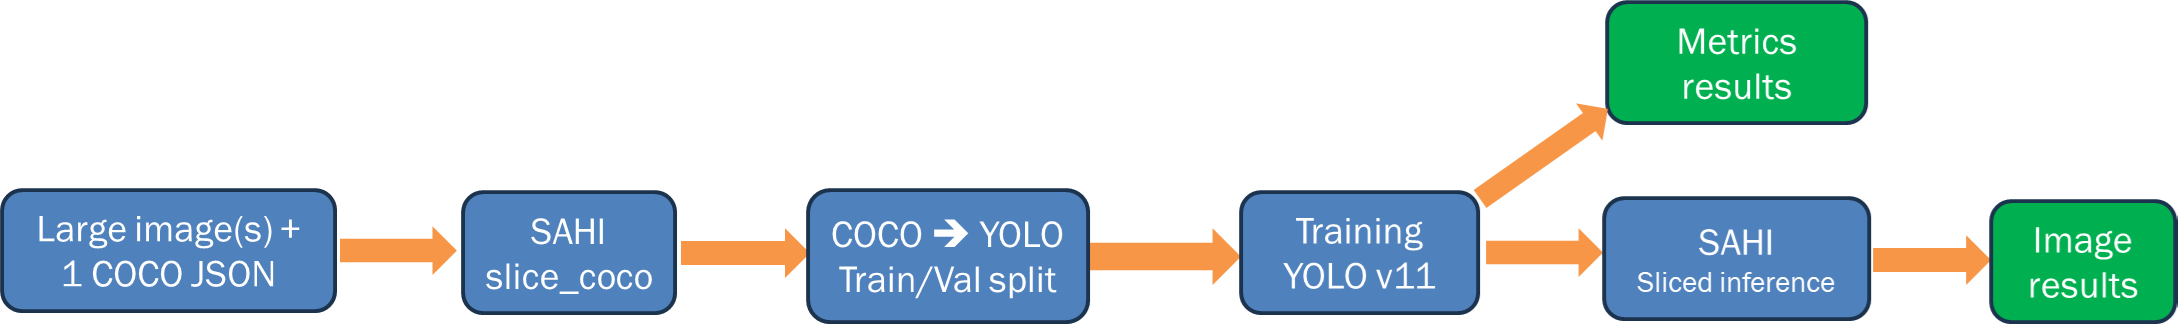

## *Learning objectives*

* Slice large images+annotations using **SAHI**
* Convert COCO json annotations to YOLO format
* Train a YOLO object detection model on sliced images.
* Perform sliced inference on **large** images using trained YOLO models.
* Extract and visualize object detection outputs.

## Use GPU in Google Colab

Navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training process.

Check if we have we access to GPU, using `nvidia-smi` command

In [1]:
!nvidia-smi

Wed Oct 22 17:09:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             54W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# Clear GPU cache
import torch
torch.cuda.empty_cache()

# if not work, restart the session

# 1. Install the required library: SAHI, ultralytics

In [2]:
pip install sahi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88


In [3]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.3 MB/s eta 0:00:00


# 2. Download data

data credit to **Joshua Konkol** and **Jeffrey Rollins**

In [4]:
# First install gdown (if not already installed)
!pip install -q gdown

import gdown
# The URL of the shared Google Drive folder
url = "https://drive.google.com/drive/folders/1eIIZVPAQSzX4dnUjOK6j43YKUO1DIcw2?usp=sharing"

# Download the folder to your current working directory
gdown.download_folder(url, quiet=False, use_cookies=False)

Retrieving folder contents


Retrieving folder 1T2mDXQuU5n4BUgVUuXr8TQ0cCfuRzk_x test_large_images
Processing file 1Dmhb6xbeFxX61-ARd7u143OtXIrs7XM7 LauA_-2_2.png
Processing file 1YI4V1S1XgIJhsX4Xqyk8IybiB1mrpDMv LauC_-2_3_ch00.tif
Retrieving folder 1h0DZ-I45E-uWpNaHVYNoJvmrr7lbx4Os train_large
Processing file 1CJS9ETA39l9SU7_m976JanhFdo2sm76p LauC_0_1.json
Processing file 1unudzIO2f4RrHx6e9UrPh6tu_iiOXG_a LauC_0_1.png


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1Dmhb6xbeFxX61-ARd7u143OtXIrs7XM7
From (redirected): https://drive.google.com/uc?id=1Dmhb6xbeFxX61-ARd7u143OtXIrs7XM7&confirm=t&uuid=eabcdf80-2ff3-4e18-9931-52962518d6b0
To: /content/data/test_large_images/LauA_-2_2.png
100%|██████████| 259M/259M [00:07<00:00, 36.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1YI4V1S1XgIJhsX4Xqyk8IybiB1mrpDMv
From (redirected): https://drive.google.com/uc?id=1YI4V1S1XgIJhsX4Xqyk8IybiB1mrpDMv&confirm=t&uuid=74a37d7f-a1cb-4dfb-a012-1137f18cc22e
To: /content/data/test_large_images/LauC_-2_3_ch00.tif
100%|██████████| 1.33G/1.33G [00:14<00:00, 90.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CJS9ETA39l9SU7_m976JanhFdo2sm76p
To: /content/data/train_large/LauC_0_1.json
100%|██████████| 1.57M/1.57M [00:00<00:00, 147MB/s]
Downloading...
From (original): https:

['/content/data/test_large_images/LauA_-2_2.png',
 '/content/data/test_large_images/LauC_-2_3_ch00.tif',
 '/content/data/train_large/LauC_0_1.json',
 '/content/data/train_large/LauC_0_1.png']

# 3. Slice Large images and their COCO annotations using SAHI

https://github.com/obss/sahi

In [5]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from sahi.slicing import slice_coco
from sahi.utils.file import load_json

## 3.1 Replace class ids

In [6]:
# replace label names in josn

import json

def replace_coco_category_id(input_file, output_file, old_id, new_id):
    """
    Replaces a category ID in a COCO JSON annotation file.

    Args:
        input_file (str): Path to the input COCO JSON file.
        output_file (str): Path to the output JSON file.
        old_id (int): The category ID to be replaced.
        new_id (int): The new category ID.
    """
    with open(input_file, 'r') as f:
        data = json.load(f)

    # Validate that the old_id exists in the categories list
    old_category_found = False
    for category in data['categories']:
        if category['id'] == old_id:
            old_category_found = True
            break

    if not old_category_found:
        print(f"Error: Category with ID {old_id} not found in the input JSON.")
        return

    # Update the categories list
    for category in data['categories']:
        if category['id'] == old_id:
            category['id'] = new_id
            print(f"Updated category ID in the 'categories' list from {old_id} to {new_id}.")
            break

    # Update the category_id in the annotations list
    annotations_updated_count = 0
    for annotation in data['annotations']:
        if annotation['category_id'] == old_id:
            annotation['category_id'] = new_id
            annotations_updated_count += 1

    if annotations_updated_count > 0:
        print(f"Updated category ID in {annotations_updated_count} annotations.")
    else:
        print(f"No annotations found with category ID {old_id}.")

    # Save the updated data to the new output file
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Successfully saved the updated JSON to {output_file}.")

class id for vessel: 1322835112 --> 0

In [7]:
input_json_path = "/content/data/train_large/LauC_0_1.json"
output_json_path = "/content/data/train_large/LauC_0_1_correct_1ID.json"
old_category_id = 1322835112  # The old category ID
new_category_id = 0     # The new category ID

# Assuming you have a COCO JSON file named 'your_input.json'
replace_coco_category_id(input_json_path, output_json_path, old_category_id, new_category_id)

Updated category ID in the 'categories' list from 1322835112 to 0.
Updated category ID in 3044 annotations.
Successfully saved the updated JSON to /content/data/train_large/LauC_0_1_correct_1ID.json.


class id for tylose: 3724679054 --> 1

In [8]:
input_json_path = "/content/data/train_large/LauC_0_1_correct_1ID.json"
output_json_path = "/content/data/train_large/LauC_0_1_correct_2IDs.json"
old_category_id = 3724679054  # The old category ID
new_category_id = 1     # The new category ID

# Assuming you have a COCO JSON file named 'your_input.json'
replace_coco_category_id(input_json_path, output_json_path, old_category_id, new_category_id)

Updated category ID in the 'categories' list from 3724679054 to 1.
Updated category ID in 86 annotations.
Successfully saved the updated JSON to /content/data/train_large/LauC_0_1_correct_2IDs.json.


## 3.2 slicing large image and COCO json

In [9]:
coco_json_path = "/content/data/train_large/LauC_0_1_correct_2IDs.json"
image_folder = "/content/data/train_large/"
out_folder = "/content/data/train_sliced_images"

coco_dict, coco_path = slice_coco(
    coco_annotation_file_path=coco_json_path,
    image_dir=image_folder,
    output_coco_annotation_file_name="sliced_LauC01_640x640",
    ignore_negative_samples=False, # target objects (positive samples), not the target object (negative samples)
    output_dir=out_folder,
    slice_height=640,
    slice_width=640,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    min_area_ratio=0.5, # If the cropped annotation area to original annotation ratio is smaller than this value, the annotation is filtered out. default=0.1
    verbose=False # not show the process details
)

100%|██████████| 1/1 [04:09<00:00, 249.57s/it]


5 min to slice one image

In [10]:
sliced_json_path = str(coco_path)
sliced_json_path

'/content/data/train_sliced_images/sliced_LauC01_640x640_coco.json'

## 3.3 Visualize sliced annotations on sliced images:

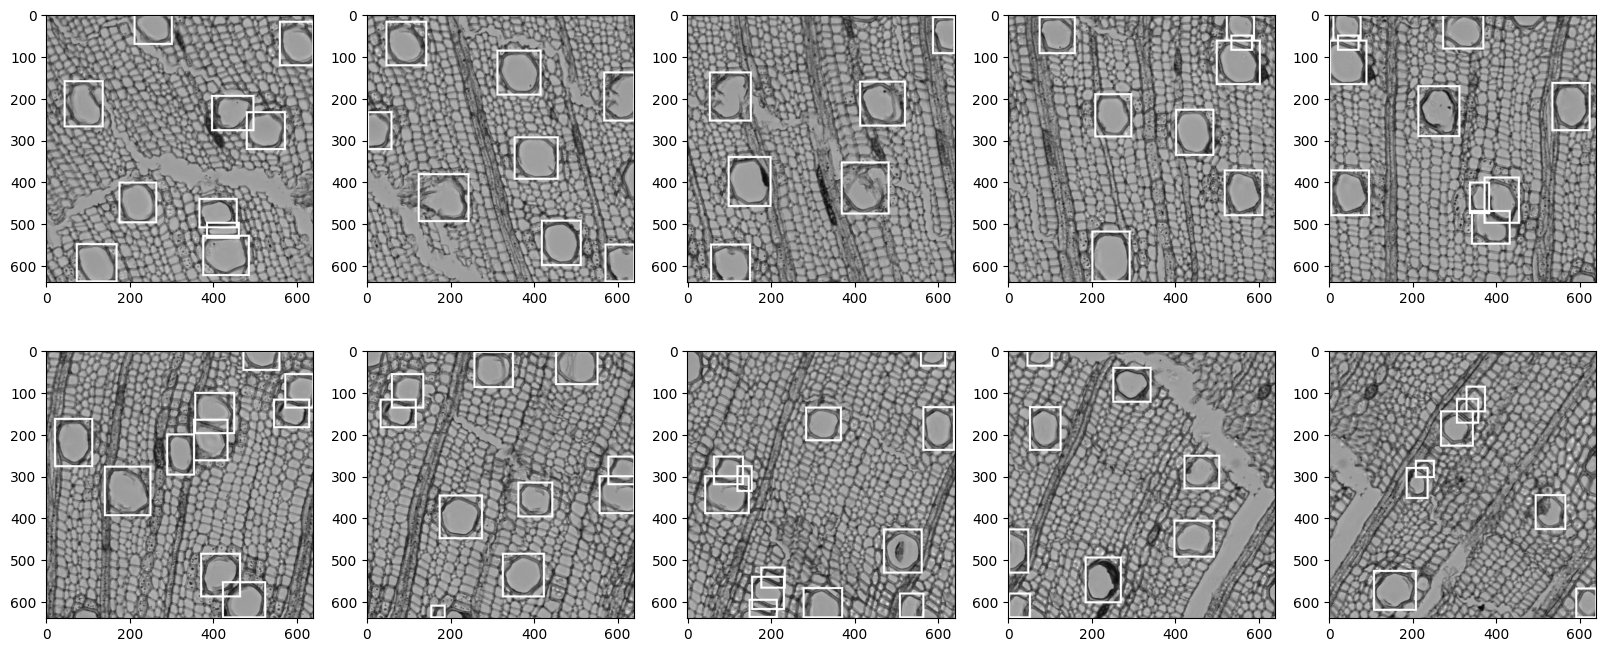

In [11]:
import os
f, axarr = plt.subplots(2, 5, figsize=(20,8))
img_ind = 150
for row_ind in range(2):
    for column_ind in range(5):
        # read image
        img = Image.open(os.path.dirname(sliced_json_path) + "/" + coco_dict["images"][img_ind]["file_name"]).convert('RGBA')

        # iterate over all annotations
        for ann_ind in range(len(coco_dict["annotations"])):

            # find annotations that belong the selected image
            if coco_dict["annotations"][ann_ind]["image_id"] == coco_dict["images"][img_ind]["id"]:

                # convert coco bbox to pil bbox
                xywh = coco_dict["annotations"][ann_ind]["bbox"]
                xyxy = [xywh[0], xywh[1], xywh[0]+xywh[2], xywh[1]+xywh[3]]

                # visualize bbox over image
                ImageDraw.Draw(img, 'RGBA').rectangle(xyxy, width=5)

        axarr[row_ind, column_ind].imshow(img) # indentation is not correct in https://github.com/obss/sahi/blob/main/demo/slicing.ipynb
        img_ind += 1

## 3.4 Check the size of the annotations

In [12]:
# area distribtution, maxium area, annotation_id
areas = []
max = 0
annotation_id=0

for ann_ind in range(len(coco_dict["annotations"])):
    areas.append(coco_dict["annotations"][ann_ind]["area"])

    if coco_dict["annotations"][ann_ind]["area"] > max:
        max = coco_dict["annotations"][ann_ind]["area"]
        annotation_id = ann_ind

print(len(areas))
print(max, annotation_id)

4898
20348 4692


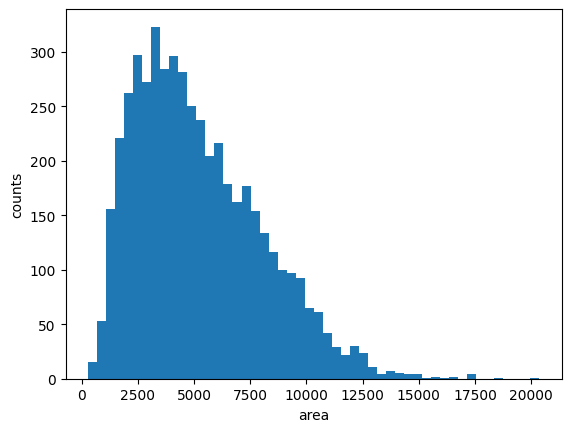

In [13]:
plt.hist(areas, bins=50)
plt.ylabel("counts")
plt.xlabel("area")
plt.show()

## 3.5 small areas

In [14]:
# find out the annotation_id and img_id < a value
counter = 0
for ann_ind in range(len(coco_dict["annotations"])):
    if coco_dict["annotations"][ann_ind]["area"] < 700:
        counter += 1
        # print("annotation_index:", ann_ind, "area:", coco_dict["annotations"][ann_ind]["area"], "image_id:", coco_dict["annotations"][ann_ind]["image_id"]) # print the annotation_index, area and image_ID (not index)!
print(counter)

15


In [15]:
def draw_ann(path, condition, area_threshold):
    coco_dict = load_json(path)
    # find out the ann_id and img_id < min_area
    ann_img_ids = {}
    if condition == "less_than":
        for ann_id in range(len(coco_dict["annotations"])):
            if coco_dict["annotations"][ann_id]["area"] < area_threshold:
                ann_img_ids[ann_id] = coco_dict["annotations"][ann_id]["image_id"]
    elif condition == "greater_than":
        for ann_id in range(len(coco_dict["annotations"])):
            if coco_dict["annotations"][ann_id]["area"] > area_threshold:
                ann_img_ids[ann_id] = coco_dict["annotations"][ann_id]["image_id"]
    print(ann_img_ids)

    # plot
    row_num = -(-len(ann_img_ids)//4)
    f, axarr = plt.subplots(row_num, 4, figsize=(24,12))
    row_ind = 0
    column_ind = 0
    for ann_ind in ann_img_ids:
        img_id = ann_img_ids[ann_ind]
        img_ind = img_id - 1
        img = Image.open(os.path.dirname(path) + "/" + coco_dict["images"][img_ind]["file_name"]).convert('RGBA')

        xywh = coco_dict["annotations"][ann_ind]["bbox"]
        xyxy = [xywh[0], xywh[1], xywh[0]+xywh[2], xywh[1]+xywh[3]]
        # visualize bbox over image
        ImageDraw.Draw(img, 'RGBA').rectangle(xyxy, width=5)
        axarr[row_ind, column_ind].imshow(img) # indentation is not correct in https://github.com/obss/sahi/blob/main/demo/slicing.ipynb
        column_ind += 1
        if column_ind % 4 == 0:
            row_ind += 1
        if column_ind == 4:
            column_ind = 0

{1574: 337, 1584: 338, 1705: 349, 1735: 350, 1763: 351, 1812: 355, 2156: 383, 2276: 399, 2320: 403, 2418: 408, 2420: 408, 2454: 409, 2610: 427, 3405: 517, 3416: 518}


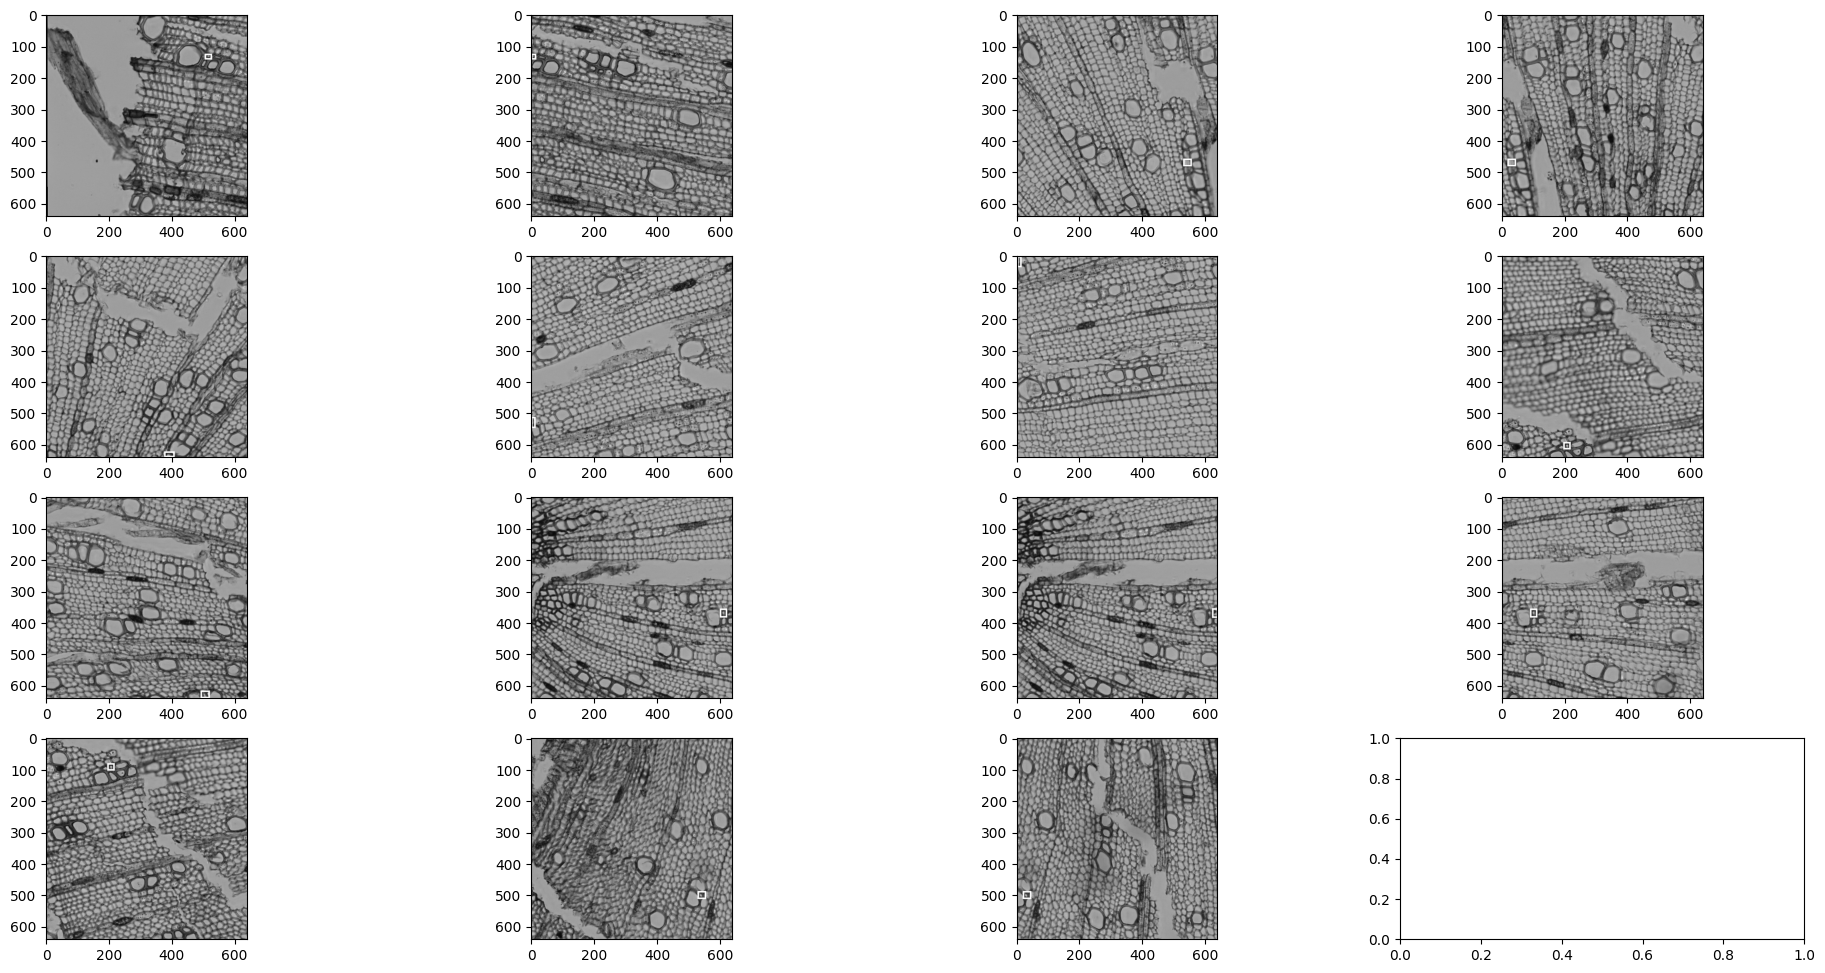

In [16]:
draw_ann(coco_path, "less_than", 700)

# 4. Convert sliced COCO to YOLO object detection annotation format

In [17]:
coco2yolo_log = !sahi coco yolo --image_dir "/content/data/train_sliced_images" \
                                --dataset_json_path $sliced_json_path \
                                --train_split 0.9

In [18]:
sliced_yolo_root_path = coco2yolo_log[-1].split("exported to ")[1]
sliced_yolo_root_path

'runs/coco2yolo/exp'

# 5. Train YOLO11x object detection

In [19]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image

model = YOLO('yolo11x.pt')  # Transfer the weights from a pretrained model (recommended for training)

#Define a project --> Destination directory for all results
project = "yolov11_res_20251022"
#Define subdirectory for this specific training
name = "200_epochs-" #note that if you run the training again, it creates a directory: 100_epochs-2

# Train the model
model.train(data=f'/content/{sliced_yolo_root_path}/data.yml',
            device=0, # device=cpu, or 'device=0' or 'device=0,1,2,3' for Multi-GPU.
            project=project,
            name=name,
            epochs=200,
            patience=0, #I am setting patience=0 to disable early stopping.
            batch=32,
            agnostic_nms=True, # NMS selects the single best bounding box for each object and suppresses all other overlapping boxes that are considered non-maximal.
            resume=False, # True if resume from the previous interupted training
            imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=True, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/runs/coco2yolo/exp/data.yml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c5ad114f500>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

# 6. Sliced inference on large images using trained model

In [20]:
from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.predict import predict
from IPython.display import Image

In [21]:
model_path=f"/content/{project}/{name}/weights/best.pt"
model_config_path = f"/content{project}/{name}/args.yaml"  # agnostic_nms=True in this file
images_dir = "/content/data/test_large_images"

In [22]:
model_path

'/content/yolov11_res_20251022/100_epochs-/weights/best.pt'

In [23]:
predict(
    model_type="yolov11",
    model_path=model_path,
    model_config_path=model_config_path,
    postprocess_class_agnostic=True,
    model_device="cuda:0", # "cpu" or 'cuda:0'
    model_confidence_threshold=0.4,
    source=images_dir,
    slice_height=640,
    slice_width=640,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    visual_bbox_thickness=1,
    visual_text_size=0.5,
    visual_text_thickness=1,
    export_pickle=True
)

# Prediction results will be exported to runs/predict/exp

There are 2 listed files in folder: test_large_images/


Performing inference on images:   0%|          | 0/2 [00:16<?, ?it/s]

Performing prediction on 1722 slices.


Performing inference on images:   0%|          | 0/2 [01:24<?, ?it/s]

Prediction time is: 68006.56 ms


Performing inference on images:  50%|█████     | 1/2 [01:53<01:48, 108.56s/it]

Performing prediction on 900 slices.


Performing inference on images:  50%|█████     | 1/2 [02:30<01:48, 108.56s/it]

Prediction time is: 36030.84 ms


Performing inference on images: 100%|██████████| 2/2 [02:42<00:00, 81.16s/it]


Prediction results are successfully exported to runs/predict/exp


# 7. Post analysis -- count predicted vessels/tyloses!

In [24]:
import pickle
import json
import os, glob

In [25]:
# Construct the full path to the pickle file
pickle_file_path = "/content/runs/predict/exp/pickles/LauA_-2_2.pickle"

# Load the data from the pickle file
with open(pickle_file_path, 'rb') as f:
    object_prediction_list = pickle.load(f)

len(object_prediction_list)

# The loaded object is a list of PredictionResult objects
# You can now iterate through the list to extract information

vessel_counter = 0
tylose_counter = 0
for prediction in object_prediction_list:
    # Access the prediction's details
    # print(f"Prediction Class Name: {prediction.category.name}")
    # print(f"Prediction Score: {prediction.score.value}")
    # print(f"Bounding Box: {prediction.bbox.to_xyxy()}")

    if prediction.category.name == "vessel":
        vessel_counter += 1
    elif prediction.category.name == "tylose":
        tylose_counter += 1

    # A PredictionResult object has many attributes; for example:
    # prediction.bbox: Bounding box coordinates
    # prediction.score: Confidence score
    # prediction.category: Predicted category object
    # For more details, see the SAHI documentation on the PredictionResult object


In [26]:
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(12181.387451171875, 12695.617370605469, 12286.138793945312, 12796.871154785156), w: 104.7513427734375, h: 101.2537841796875>,
    mask: None,
    score: PredictionScore: <value: 0.9453350305557251>,
    category: Category: <id: 1, name: tylose>>

In [27]:
def count_prediction_results(pkl_path):
    # Load the data from the pickle file
    with open(pkl_path, 'rb') as f:
        object_prediction_list = pickle.load(f)

    vessel_counter = 0
    tylose_counter = 0
    for prediction in object_prediction_list:
        if prediction.category.name == "vessel":
            vessel_counter += 1
        elif prediction.category.name == "tylose":
            tylose_counter += 1

    img_name = pkl_path.split("/")[-1].split(".")[0]
    print(img_name, "\t vessel:", vessel_counter, "\t tylose:", tylose_counter)

    return vessel_counter, tylose_counter

In [28]:
# iglob to process the matched files one by one rather than loading all of the filenames into memory at once.
for filepath in glob.iglob('/content/runs/predict/exp/pickles/*.pickle'):
    count_prediction_results(filepath)

LauC_-2_3_ch00 	 vessel: 35 	 tylose: 0
LauA_-2_2 	 vessel: 2755 	 tylose: 35
